# Using the Modo API

In [21]:
import dotenv
import requests
import pandas as pd
import numpy as np
import json
import matplotlib.pyplot as plt
from matplotlib.animation import FuncAnimation
import linopy

In [22]:
start_date = "2024-11-05T02:22:22"
end_date = "2024-11-13T08:22:22"
limit = "10000"

url = "https://api.modoenergy.com/pub/v1/gb/elexon/system/fuelhh?publish_date_from=" + start_date + "&publish_date_to=" + end_date + "&limit=" + limit
# this endpoint gives the average generation of each fuel type in the UK for each half hour period in MW
headers = {
    "accept": "application/json",
    # import token from .env
    "X-Token": dotenv.get_key(dotenv.find_dotenv(), 'modo')
}

response = requests.get(url, headers=headers)

# print(response.text)

In [23]:

url2 = "https://api.modoenergy.com/pub/v1/gb/elexon/system/indo?publish_date_from=" + start_date + "&publish_date_to=" + end_date + "&limit=" + limit

headers_demand = {
    "accept": "application/json",
    "X-Token": dotenv.get_key(dotenv.find_dotenv(), 'modo')
}

response_demand = requests.get(url2, headers=headers_demand)

In [45]:
# convert the response to pandas dataframe

data = json.loads(response.text)
data_demand = json.loads(response_demand.text)

df = pd.DataFrame(data['results'])
df_demand = pd.DataFrame(data_demand['results'])

# convert startTime to datetime
df['publishTime'] = pd.to_datetime(df['publishTime'])
df_demand['publishTime'] = pd.to_datetime(df_demand['publishTime'])

# average over each day and remove time
df['day'] = df['publishTime'].dt.date
df_demand['day'] = df_demand['publishTime'].dt.date



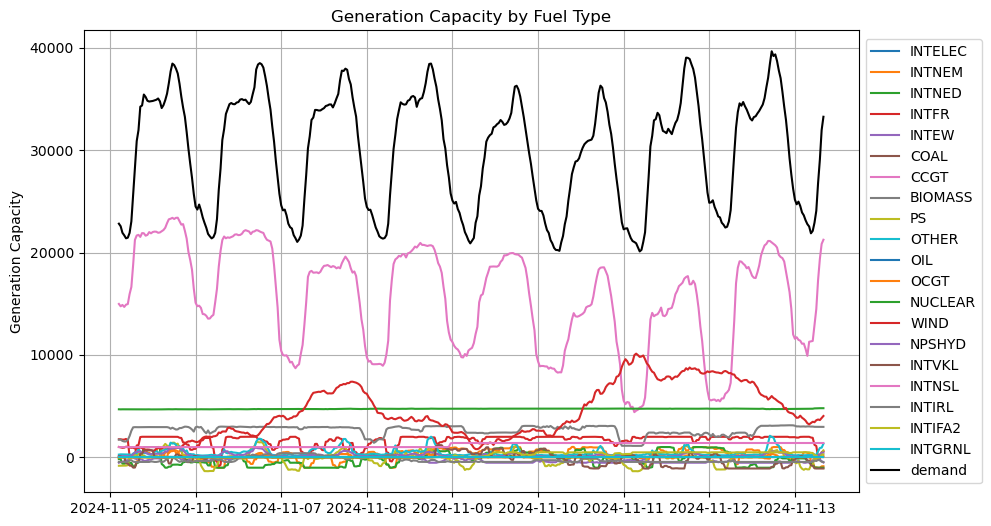

In [46]:
# plot a breakfdown of the fuel types generation capacity over the time period

# for each day
# for each fuel type plot a different color on the graph
# x-axis is the time
# y-axis is the generation capacity

# plot the graph
plt.figure(figsize=(10, 6))
for fuel_type in df['fuelType'].unique():
    fuel_df = df[df['fuelType'] == fuel_type]
    plt.plot(fuel_df['publishTime'], fuel_df['generation'], label=fuel_type)

# plot demand
plt.plot(df_demand['publishTime'], df_demand['demand'], label='demand', color='black')

# only label the x-axis every 100th value
plt.ylabel('Generation Capacity')
plt.title('Generation Capacity by Fuel Type')

# legend outside the plot
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.grid()

plt.show()


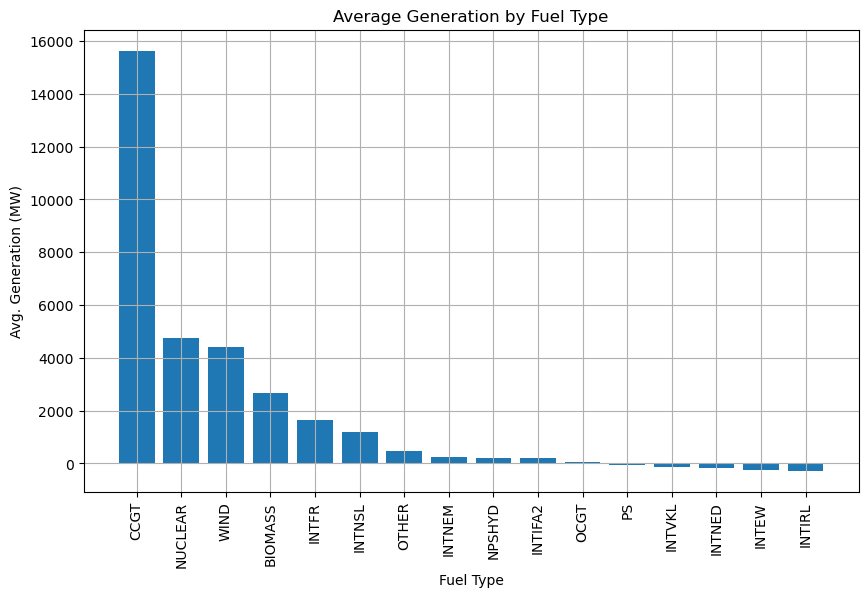

In [47]:
# how much are we generating on average for each fuel type over the time period
average_generation = df.groupby('fuelType')['generation'].mean().sort_values(ascending=False)
average_generation = average_generation[average_generation != 0]

# plot as a bar chart
plt.figure(figsize=(10, 6))
plt.bar(average_generation.index, average_generation)
plt.title('Average Generation by Fuel Type')
plt.ylabel('Avg. Generation (MW)')
plt.xlabel('Fuel Type')
plt.xticks(rotation=90)
# remove columns with average generation of 0
plt.grid()
plt.show()


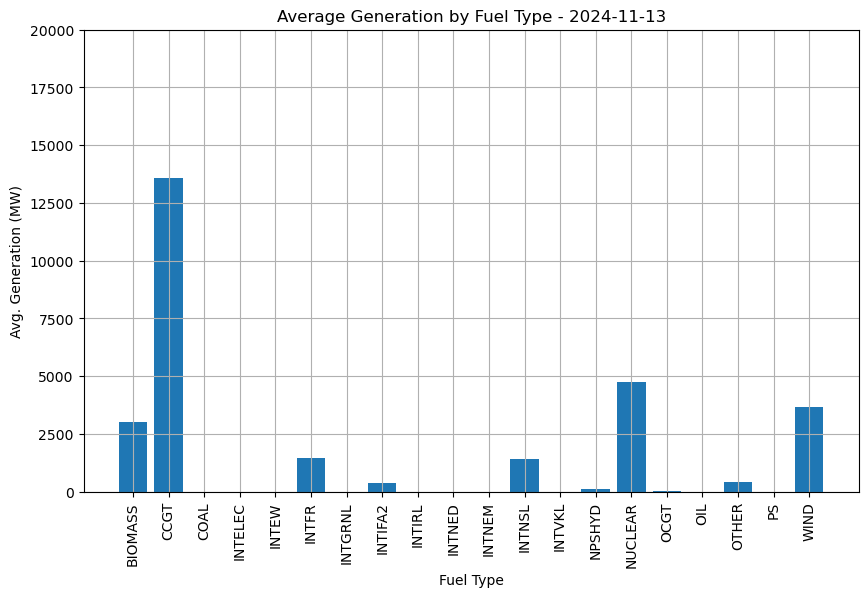

In [48]:

# Prepare figure
fig, ax = plt.subplots(figsize=(10, 6))

days = df['settlementDate'].unique()

def update(day):
    ax.clear()
    daily_data = df[df['settlementDate'] == day]
    average_generation = daily_data.groupby('fuelType')['generation'].mean()
    # average_generation = average_generation[average_generation != 0]  # Exclude 0 generation
    
    ax.bar(average_generation.index, average_generation)
    ax.set_title(f'Average Generation by Fuel Type - {day}')
    ax.set_ylabel('Avg. Generation (MW)')
    # set y limit to the maximum value of the average generation
    ax.set_ylim(0, 20000)
    ax.set_xlabel('Fuel Type')
    ax.set_xticks(range(len(average_generation.index)))
    ax.set_xticklabels(average_generation.index, rotation=90)
    ax.grid()

# Create animation
ani = FuncAnimation(fig, update, frames=days, repeat=False)




In [49]:
# To display the animation in Jupyter Notebook
from IPython.display import HTML
HTML(ani.to_jshtml())

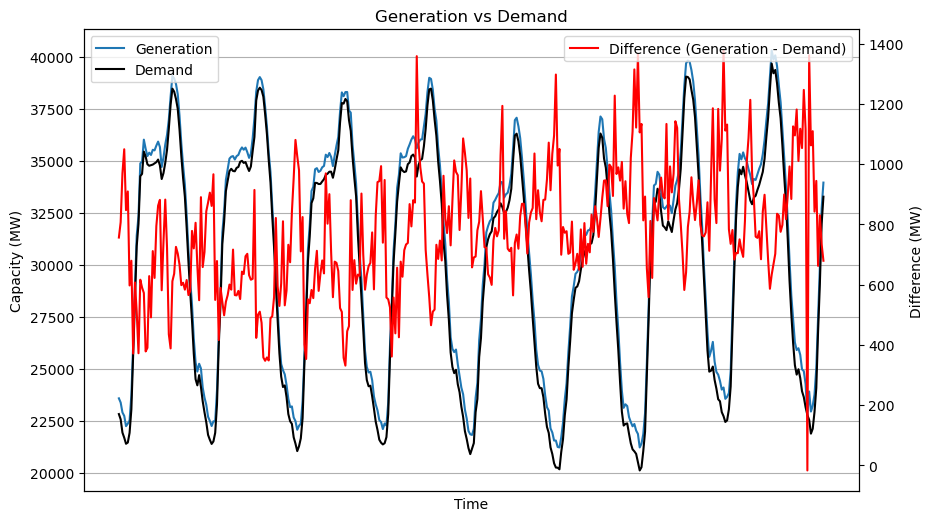

In [50]:
# Calculate total generation and difference
total_generation = df.groupby('publishTime')['generation'].sum()
difference = total_generation -df_demand.set_index('publishTime')['demand'] 

# Plot generation and demand on the primary y-axis
fig, ax1 = plt.subplots(figsize=(10, 6))

ax1.plot(total_generation.index, total_generation, label='Generation')
ax1.plot(df_demand['publishTime'], df_demand['demand'], label='Demand', color='black')
ax1.set_title('Generation vs Demand')
ax1.set_ylabel('Capacity (MW)')
ax1.set_xlabel('Time')
ax1.grid()
ax1.legend(loc='upper left')
ax1.set_xticks([])  # Hide x-axis labels

# Plot the difference on the secondary y-axis
ax2 = ax1.twinx()
ax2.plot(difference.index, difference, label='Difference (Generation - Demand)', color='red')
ax2.set_ylabel('Difference (MW)')
ax2.legend(loc='upper right')

plt.show()


# Energy Portfolio Optimiser for Maximum Sustainability

Aim to minimise carbon emissions

## Decision Variables

- energy production from each source
- energy cost from each source
- carbon emissions from each source

## Constraints

- energy demand
- energy production from each source - variable eg: solar sinunoidal


## Objective

- minimise carbon emissions









In [ ]:
# get a new set of data for: production_capacity, demand, price and CO2 emissions
start_date = "2024-11-05T02:22:22"
end_date = "2024-11-13T08:22:22"

prod_url = "https://api.modoenergy.com/pub/v1/gb/elexon/system/fuelhh?publish_date_from=" + start_date + "&publish_date_to=" + end_date + "&limit=" + limit
demand_url = "https://api.modoenergy.com/pub/v1/gb/elexon/system/indo?publish_date_from=" + start_date + "&publish_date_to=" + end_date + "&limit=" + limit
price_url = "https://api.modoenergy.com/pub/v1/gb/elexon/system/price?publish_date_from=" + start_date + "&publish_date_to=" + end_date + "&limit=" + limit
co2_url = "https://api.modoenergy.com/pub/v1/gb/elexon/system/co2?publish_date_from=" + start_date + "&publish_date_to=" + end_date + "&limit=" + limit

urls = [prod_url, demand_url, price_url, co2_url]

headers = {
    "accept": "application/json",
    "X-Token": dotenv.get_key(dotenv.find_dotenv(), 'modo')
}

responses = [requests.get(url, headers=headers) for url in urls]

# convert the response to pandas dataframe
data = [json.loads(response.text) for response in responses]
dfs = [pd.DataFrame(d['results']) for d in data]

# convert startTime to datetime
for df in dfs:
    df['publishTime'] = pd.to_datetime(df['publishTime'])



In [ ]:
from scipy.optimize import linprog

# generation by fuel type average for each day
# df:  rows = days, columns = fuel types, values = average generation
# the production capacities are the values
# production_capacities = [100, 80, 50]  # Average power (MW) from each source that day (days x fuels) matrix
production_capacities = df.pivot_table(index='day', columns='fuelType', values='generation', aggfunc='mean').fillna(0).values

# sustainability_weights are the carbon equivalent emissions for each source
# df: columns = fuel types, values = carbon equivalent emissions (1 x fuels) matrix
# sustainability_weights = [0.5, 0.3, 0.2]  # Carbon equivalent emissions (kgCO2e/MWh) for each source (fuels x 1) matrix
sustainability_weights = df.groupby('fuelType')['carbonEquivalent'].mean().sort_values(ascending=False).values

# demand is the total demand for that day
# df_demand: rows = days, values = total demand (days x 1) matrix
# demand = [200]  # Total demand for that day (days x 1) matrix
demand = df_demand.groupby('day')['demand'].mean().values

# Constraints
# A_leq * x  >= b_leq # x is the power from each source for that day, A_leq is the power from each source for that day, b_leq is the total demand for that day
A_leq = production_capacities
b_leq = demand

# Bounds
# 0 <= x <= production_capacities
bounds = [(0, capacity) for capacity in production_capacities]

# Objective
# Minimize the sum of the sustainability_weights * x
c = sustainability_weights

# Solve
result = linprog(
    c=sustainability_weights,
    A_eq=A_eq,
    b_eq=b_eq,
    bounds=bounds,
    method='highs'
)

print("Optimal energy mix:", result.x)


TypeError: agg function failed [how->mean,dtype->object]